In [1]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from models import GRU
from ANFISpy import GRUANFIS

## Pre-Processing

Importing and converting data (https://www.kaggle.com/datasets/unanimad/corona-virus-brazil/data).

In [2]:
df = pd.read_csv('brazil_covid19_macro.csv')
cases = np.diff(df['cases'].values)
cases = pd.Series(cases).rolling(window=20, center=True, min_periods=1).mean().values
dates = df['date'].values[1:]
days = np.array([i for i in range(cases.shape[0])], dtype='float32')

tick_indices = [i for i, d in enumerate(dates) if d.endswith('-01')]
tick_labels = [dates[i] for i in tick_indices]

Processing the data.

In [3]:
total_len = len(cases)  
train_size = int(0.8 * total_len)
val_size = int(0.1 * total_len)
test_size = total_len - train_size - val_size

cases_train = cases[:train_size + val_size]
cases_test = cases[train_size + val_size:]

days_train = days[:train_size + val_size]
days_test = days[train_size + val_size:]

norm_min, norm_max = cases_train.min(), cases_train.max()

cases_train = (cases_train - norm_min) / (norm_max - norm_min)
cases_test  = (cases_test - norm_min) / (norm_max - norm_min)

def create_sequences(data, seq_length):
    x = []
    y = []
    for i in range(len(data) - seq_length):
        x.append(data[i:i + seq_length])     
        y.append(data[i + 1 : i + seq_length + 1])  
    x = torch.FloatTensor(np.array(x)).unsqueeze(-1) 
    y = torch.FloatTensor(np.array(y)).unsqueeze(-1)
    return x, y

seq_len_gru = 23

x_train, y_train = create_sequences(cases_train, seq_len_gru)
x_test,  y_test  = create_sequences(cases_test, seq_len_gru)

aligned_days_train = days_train[seq_len_gru:]
aligned_days_test  = days_test[seq_len_gru:]

train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=False)

Instantianting GRU.

In [4]:
gru = GRU(
    h=71,
    activation=nn.Identity(),
)

params_gru = 0
for p in list(gru.parameters()):
    params_gru += p.flatten().shape[0]
    
print(f'Number of parameters: {params_gru}')

Number of parameters: 15834


Training the model.

In [5]:
try:
    best_model_path = 'best_models/gru_daily.pth'  
    checkpoint = torch.load(best_model_path, weights_only=True, map_location=torch.device('cpu'))
    gru.load_state_dict(checkpoint['model_state_dict'])
    print('Loaded.')

except:
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(gru.parameters(), lr=0.003081)

    epochs = 1000
    best_train_loss = float('inf')
    best_model_path = 'best_models/gru_daily.pth'

    for epoch in range(epochs):
        gru.train()
        epoch_loss_train = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = gru(X_batch)[0]
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss_train += loss.item() * X_batch.size(0) 

        epoch_loss_train /= len(train_loader.dataset)

        if epoch_loss_train < best_train_loss:
                best_train_loss = epoch_loss_train
                torch.save({
                    'model_state_dict': gru.state_dict(),
                }, best_model_path)

        if epoch % 50 == 0:
            print(f'Epoch {epoch} | Train Loss: {epoch_loss_train:.8f}')

    checkpoint = torch.load(best_model_path, weights_only=True)
    gru.load_state_dict(checkpoint['model_state_dict'])

Loaded.


Plotting training data predictions.

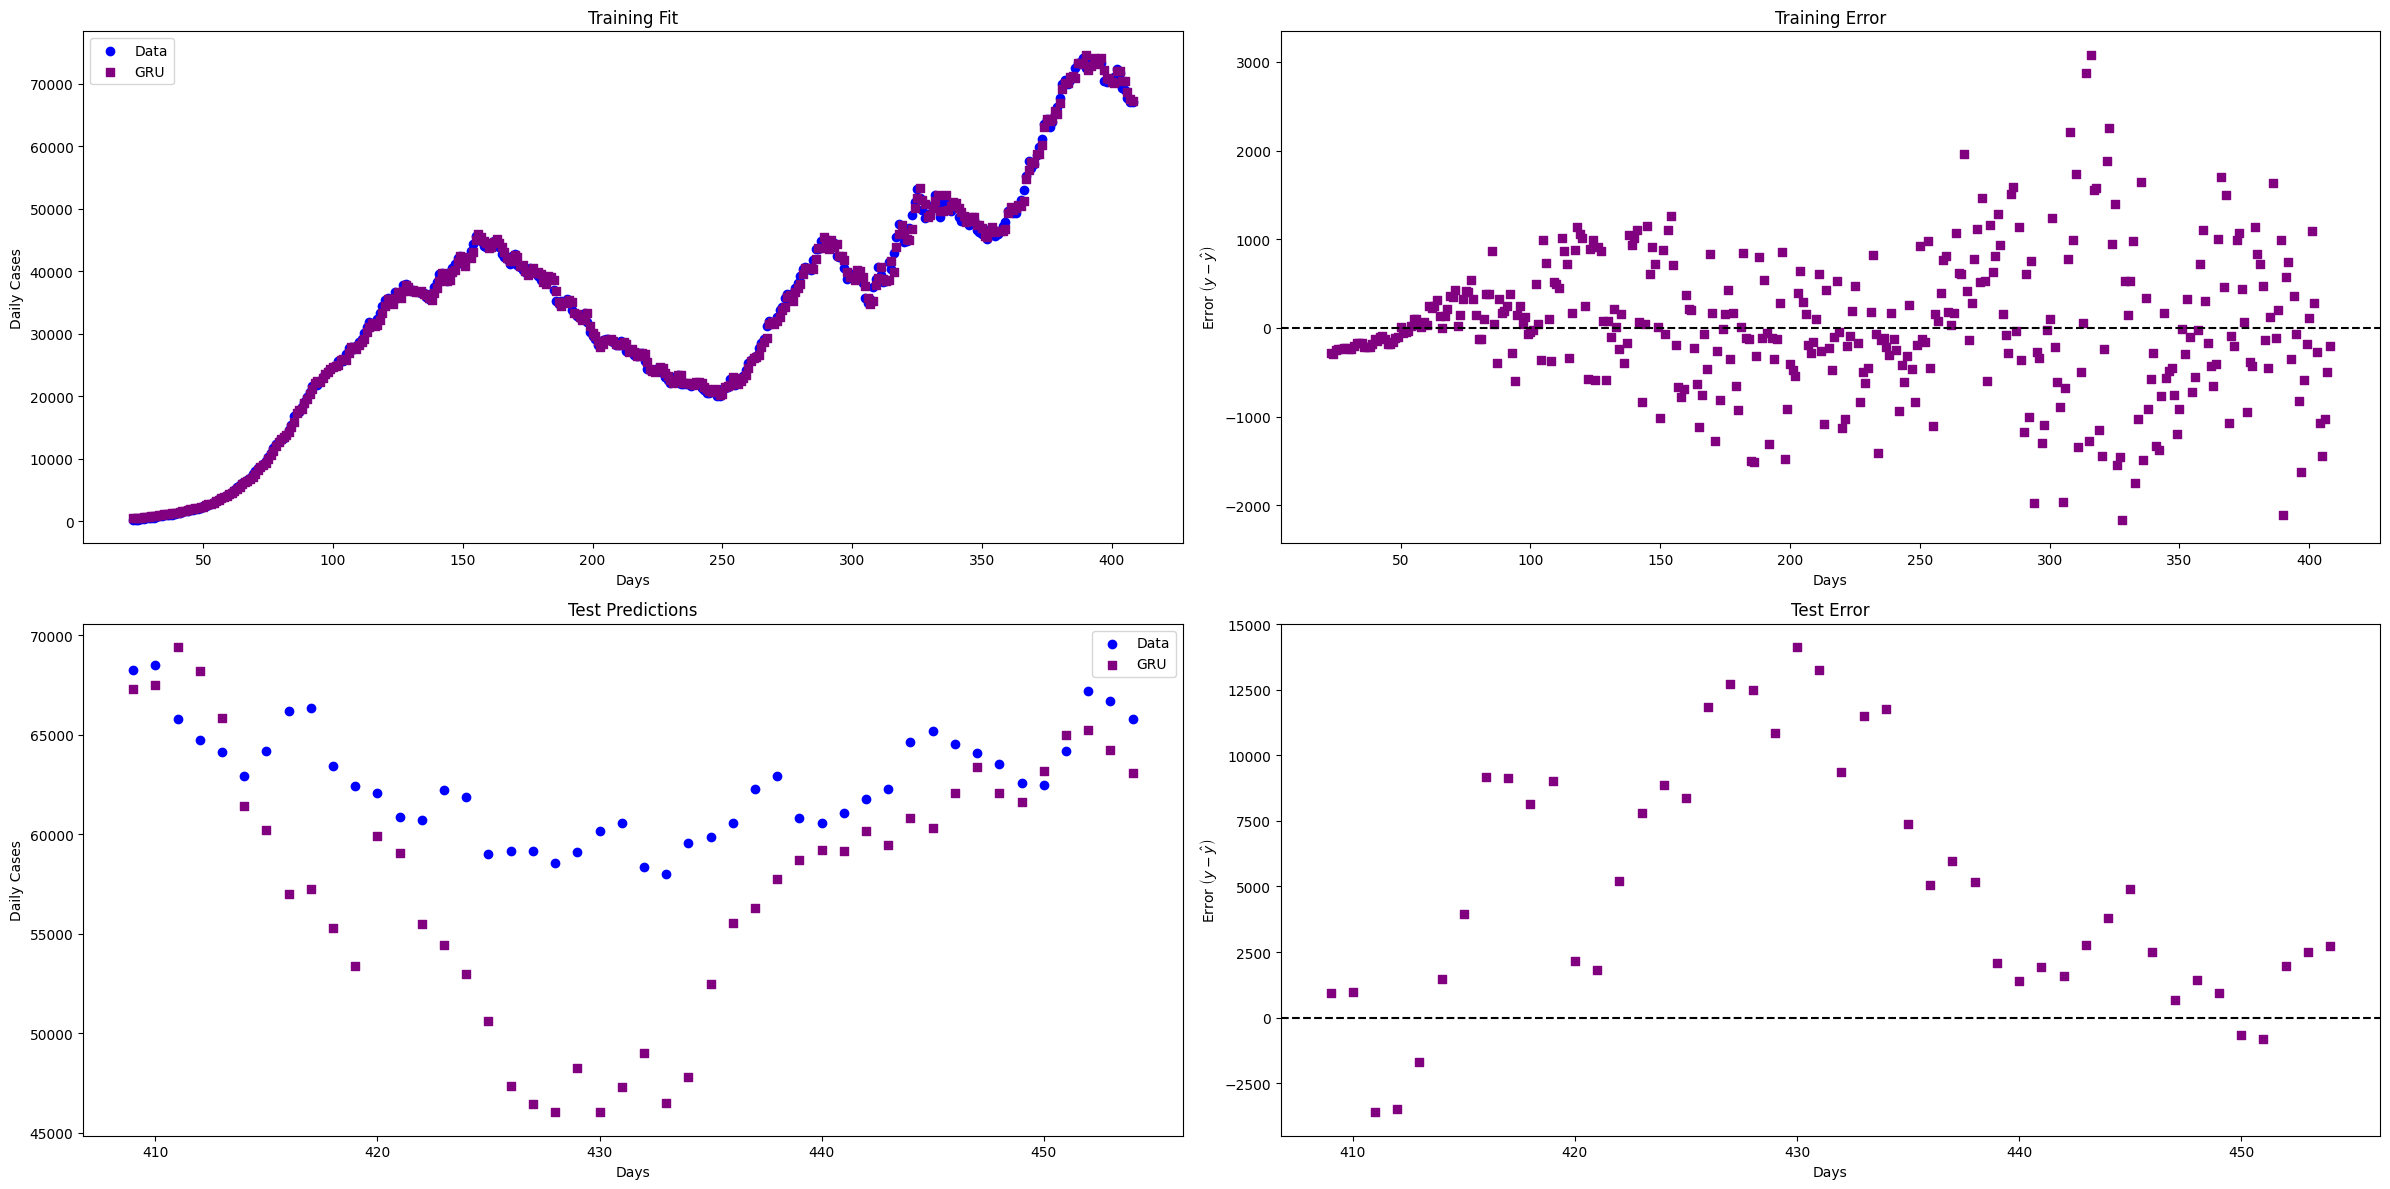

In [6]:
gru.eval()
test_predictions_gru = []

with torch.no_grad():
    train_predictions_gru = gru(x_train)[0][:, -1, :].numpy().flatten()
    
    last_data = x_train[-1:]
    h = None
    
    for _ in range(len(days_test)):  
        pred, hnew = gru(last_data, h)  
        test_predictions_gru.append(pred[:, -1:, 0].item())
        last_data = torch.cat([last_data[:, 1:, :], pred[:, -1:, :]], dim=1)  
        h = hnew
        
train_predictions_gru = train_predictions_gru * (norm_max - norm_min) + norm_min
test_predictions_gru = np.array(test_predictions_gru) * (norm_max - norm_min) + norm_min

cases_train_denorm = cases_train[seq_len_gru:] * (norm_max - norm_min) + norm_min
cases_test_denorm = cases_test * (norm_max - norm_min) + norm_min

fig, ax = plt.subplots(2, 2, figsize=(24, 12))

ax[0, 0].scatter(aligned_days_train, cases_train_denorm, label='Data', c='blue')
ax[0, 0].scatter(aligned_days_train, train_predictions_gru, label='GRU', marker='s', c='purple')
ax[0, 0].set_title("Training Fit")
ax[0, 0].set_xlabel("Days")
ax[0, 0].set_ylabel("Daily Cases")
ax[0, 0].legend()

ax[0, 1].scatter(aligned_days_train, cases_train_denorm - train_predictions_gru, color='purple', marker='s')
ax[0, 1].axhline(0, color='black', linestyle='--')
ax[0, 1].set_title("Training Error")
ax[0, 1].set_xlabel("Days")
ax[0, 1].set_ylabel(r"Error $\left(y - \hat{y}\right)$")

ax[1, 0].scatter(days_test, cases_test_denorm, label='Data', c='blue')
ax[1, 0].scatter(days_test, test_predictions_gru, label='GRU', marker='s', c='purple')
ax[1, 0].set_title("Test Predictions")
ax[1, 0].set_xlabel("Days")
ax[1, 0].set_ylabel("Daily Cases")
ax[1, 0].legend()

ax[1, 1].scatter(days_test, cases_test_denorm - test_predictions_gru, color='purple', marker='s')
ax[1, 1].axhline(0, color='black', linestyle='--')
ax[1, 1].set_title("Test Error")
ax[1, 1].set_xlabel("Days")
ax[1, 1].set_ylabel(r"Error $\left(y - \hat{y}\right)$")

plt.tight_layout()
plt.show()

## GRU-ANFIS

Instantiating model.

In [7]:
n_vars = 1
seq_len_gruanfis = 20
mf_names = [['VL', 'L', 'ML', 'MH', 'H', 'VH']]

variables = {
    'inputs': {
        'n_sets': [6],
        'uod': n_vars * [(0, 1.5)],
        'var_names': ['Cases'],
        'mf_names': n_vars * mf_names,
    },
    'output': {
        'var_names': 'New Cases',
        'n_classes': 1,
    },
}

gruanfis = GRUANFIS(
    variables, 
    'bell', 
    seq_len_gruanfis, 
    output_activation=nn.Identity(), 
    and_operator=torch.prod
)

params_gruanfis = 0
for p in list(gruanfis.parameters()):
    params_gruanfis += p.flatten().shape[0]
    
print(f'Number of parameters: {params_gruanfis}')

Number of parameters: 282


Separating data.

In [8]:
total_len = len(cases)  
train_size = int(0.8 * total_len)
val_size = int(0.1 * total_len)
test_size = total_len - train_size - val_size

cases_train = cases[:train_size + val_size]
cases_test = cases[train_size + val_size:]

days_train = days[:train_size + val_size]
days_test = days[train_size + val_size:]

norm_min, norm_max = cases_train.min(), cases_train.max()

cases_train = (cases_train - norm_min) / (norm_max - norm_min)
cases_test  = (cases_test - norm_min) / (norm_max - norm_min)

def create_sequences(data, seq_length):
    x = []
    y = []
    for i in range(len(data) - seq_length):
        x.append(data[i:i + seq_length])     
        y.append(data[i + 1 : i + seq_length + 1])  
    x = torch.FloatTensor(np.array(x)).unsqueeze(-1) 
    y = torch.FloatTensor(np.array(y)).unsqueeze(-1)
    return x, y

x_train, y_train = create_sequences(cases_train, seq_len_gruanfis)
x_test,  y_test  = create_sequences(cases_test, seq_len_gruanfis)

aligned_days_train = days_train[seq_len_gruanfis:]
aligned_days_test  = days_test[seq_len_gruanfis:]

train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=False)

Training.

In [9]:
try:
    best_model_path = 'best_models/gruanfis_daily.pth'  
    checkpoint = torch.load(best_model_path, weights_only=True)
    gruanfis.load_state_dict(checkpoint['model_state_dict'])
    print('Loaded.')

except:
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(gruanfis.parameters(), lr=0.006727)
    
    epochs = 1000
    best_train_loss = float('inf')
    best_model_path = 'best_models/gruanfis_daily.pth'
    
    for epoch in range(epochs):
        gruanfis.train()
        epoch_loss_train = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = gruanfis(X_batch)[0]
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss_train += loss.item() * X_batch.size(0) 
    
        epoch_loss_train /= len(train_loader.dataset)
    
        if epoch_loss_train < best_train_loss:
            best_train_loss = epoch_loss_train
            torch.save({
                'model_state_dict': gruanfis.state_dict(),
            }, best_model_path)
        
        if epoch % 50 == 0:
            print(f'Epoch {epoch} | Train Loss: {epoch_loss_train:.8f}')
    
    checkpoint = torch.load(best_model_path, weights_only=True)
    gruanfis.load_state_dict(checkpoint['model_state_dict'])

Loaded.


Plotting.

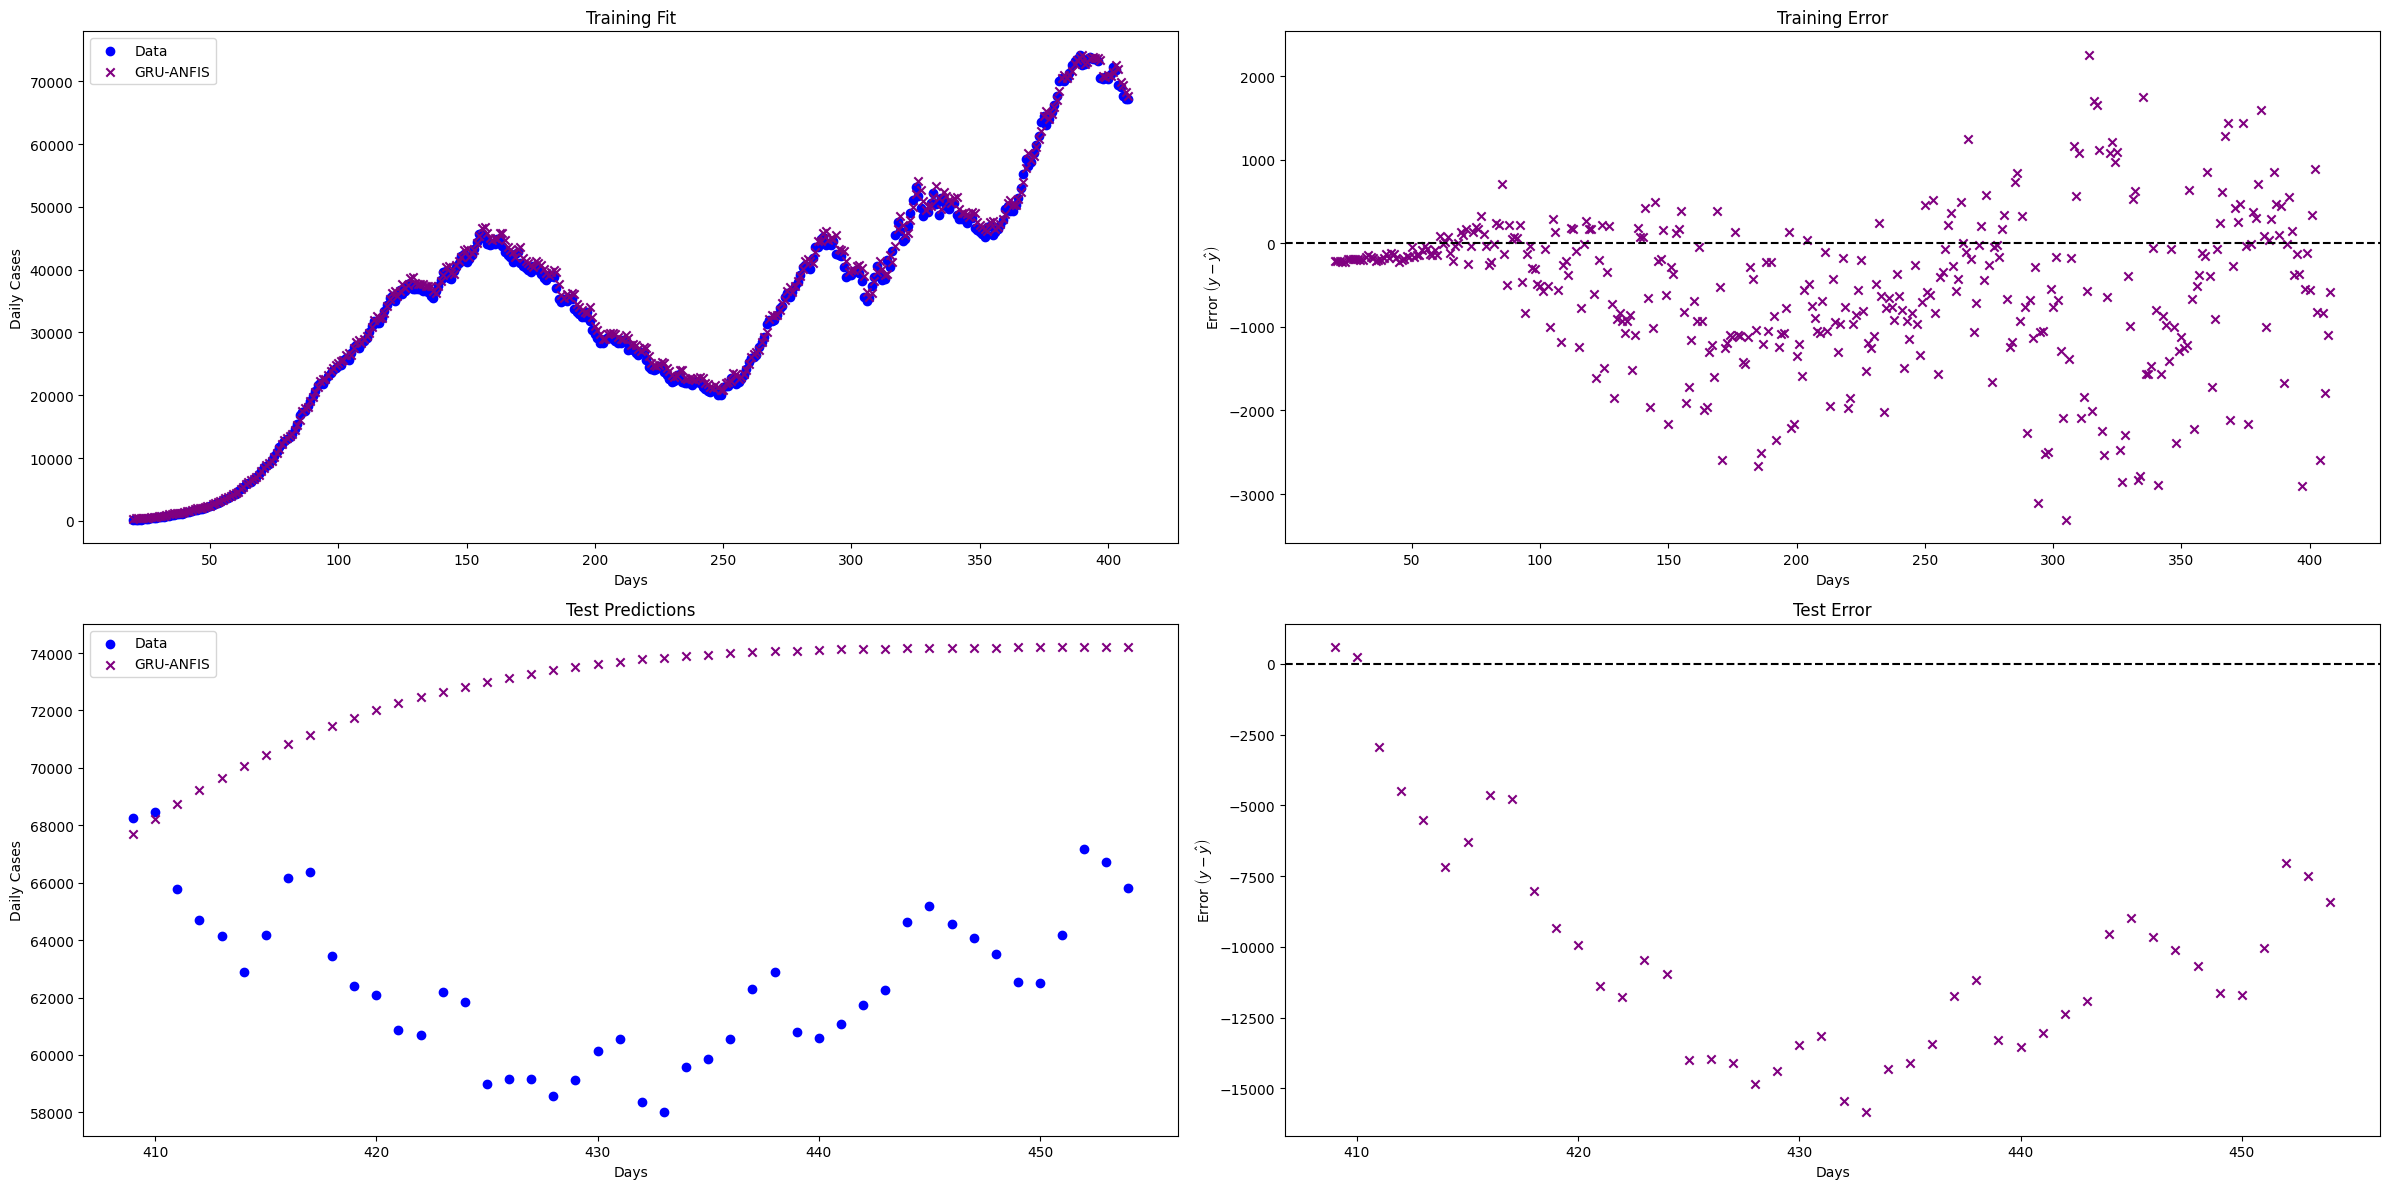

In [10]:
gruanfis.eval()
test_predictions_gruanfis = []

with torch.no_grad():
    train_predictions_gruanfis = gruanfis(x_train)[0][:, -1, :].numpy().flatten()
    
    last_data = x_train[-1:]
    h = None
    
    for _ in range(len(days_test)):  
        pred, hnew = gruanfis(last_data, h)  
        test_predictions_gruanfis.append(pred[:, -1:, :].item())
        last_data = torch.cat([last_data[:, 1:, :], pred[:, -1:, :]], dim=1)  
        h = hnew
        
train_predictions_gruanfis = train_predictions_gruanfis * (norm_max - norm_min) + norm_min
test_predictions_gruanfis = np.array(test_predictions_gruanfis) * (norm_max - norm_min) + norm_min

cases_train_denorm = cases_train[seq_len_gruanfis:] * (norm_max - norm_min) + norm_min
cases_test_denorm = cases_test * (norm_max - norm_min) + norm_min

fig, ax = plt.subplots(2, 2, figsize=(24, 12))

ax[0, 0].scatter(aligned_days_train, cases_train_denorm, label='Data', c='blue')
ax[0, 0].scatter(aligned_days_train, train_predictions_gruanfis, label='GRU-ANFIS', marker='x', c='purple')
ax[0, 0].set_title("Training Fit")
ax[0, 0].set_xlabel("Days")
ax[0, 0].set_ylabel("Daily Cases")
ax[0, 0].legend()

ax[0, 1].scatter(aligned_days_train, cases_train_denorm - train_predictions_gruanfis, color='purple', marker='x')
ax[0, 1].axhline(0, color='black', linestyle='--')
ax[0, 1].set_title("Training Error")
ax[0, 1].set_xlabel("Days")
ax[0, 1].set_ylabel(r"Error $\left(y - \hat{y}\right)$")

ax[1, 0].scatter(days_test, cases_test_denorm, label='Data', c='blue')
ax[1, 0].scatter(days_test, test_predictions_gruanfis, label='GRU-ANFIS', marker='x', c='purple')
ax[1, 0].set_title("Test Predictions")
ax[1, 0].set_xlabel("Days")
ax[1, 0].set_ylabel("Daily Cases")
ax[1, 0].legend()

ax[1, 1].scatter(days_test, cases_test_denorm - test_predictions_gruanfis, color='purple', marker='x')
ax[1, 1].axhline(0, color='black', linestyle='--')
ax[1, 1].set_title("Test Error")
ax[1, 1].set_xlabel("Days")
ax[1, 1].set_ylabel(r"Error $\left(y - \hat{y}\right)$")

plt.tight_layout()
plt.show()

## Final Analysis

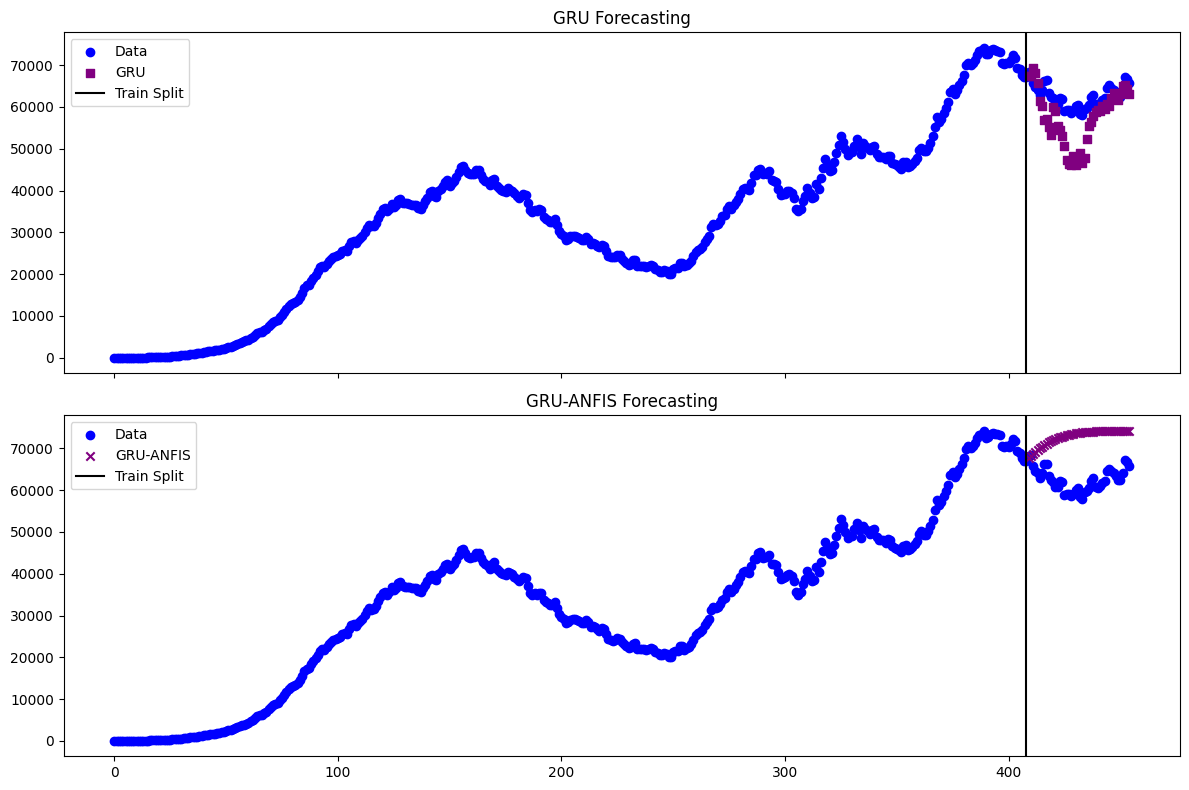

In [11]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

ax[0].scatter(days, cases, label='Data', color='blue')
ax[0].scatter(days_test, test_predictions_gru, label='GRU', color='purple', marker='s')
ax[0].axvline(days_train.max(), linestyle='-', color='black', label='Train Split')
ax[0].set_title('GRU Forecasting')
ax[0].legend()

ax[1].scatter(days, cases, label='Data', color='blue')
ax[1].scatter(days_test, test_predictions_gruanfis, label='GRU-ANFIS', color='purple', marker='x')
ax[1].axvline(days_train.max(), linestyle='-', color='black', label='Train Split')
ax[1].set_title('GRU-ANFIS Forecasting')
ax[1].legend()

plt.tight_layout()
plt.show()

In [12]:
rmse_gru = np.sqrt(np.mean((cases_test_denorm - test_predictions_gru)**2)).item()
rmse_gruanfis = np.sqrt(np.mean((cases_test_denorm - test_predictions_gruanfis)**2)).item()
mae_gru = np.mean(np.abs(cases_test_denorm - test_predictions_gru)).item()
mae_gruanfis = np.mean(np.abs(cases_test_denorm - test_predictions_gruanfis)).item()
mape_gru = 100 * np.mean(np.abs((cases_test_denorm - test_predictions_gru) / cases_test_denorm)).item()
mape_gruanfis = 100 * np.mean(np.abs((cases_test_denorm - test_predictions_gruanfis) / cases_test_denorm)).item()

print(f'GRU       | RMSE: {int(rmse_gru)}  | MAE: {int(mae_gru)}  | MAPE: {mape_gru:.2f}%  | Parameters: {params_gru}')
print(f'GRU-ANFIS | RMSE: {int(rmse_gruanfis)} | MAE: {int(mae_gruanfis)} | MAPE: {mape_gruanfis:.2f}% | Parameters: {params_gruanfis}')

GRU       | RMSE: 6831  | MAE: 5434  | MAPE: 8.86%  | Parameters: 15834
GRU-ANFIS | RMSE: 10942 | MAE: 10260 | MAPE: 16.66% | Parameters: 282
